In [19]:
using LinearAlgebra, Random, Statistics, Plots, SparseArrays
include("proxgrad.jl")
pyplot()

Plots.PyPlotBackend()

In [20]:
function generate_data(n, w)
    X = randn(n,length(w))
    y = X*w
    return X, y
end

function generate_noisy_data(n, w)
    X = randn(n,length(w))
    y = X*w + .1*randn(n)
    return X, y
end

generate_noisy_data (generic function with 1 method)

# OLS is invariant

In [21]:
d = 10
n = 20
w = randn(d)
X, y = generate_data(n, w);

In [23]:
w = X\y
@show X*w

yscale = 5*y
Xscale = 3*X
wscale = Xscale\yscale
@show Xscale*wscale / 5;

@show rel_err = norm(X*w - Xscale*wscale/5) / norm(X*w)

X * w = [2.0913847974928337, 4.440374562380611, 2.340141748911496, -1.8553098407591848, -0.9753861088629618, 1.6317704163593119, -0.39880710766016314, -0.13524683415456196, -1.8218262380358738, -0.4380319241431512, 3.1911071220036784, -3.4704803432105904, 3.2814064865744506, 0.5001591746365914, 2.631541075648928, -2.7551216528504017, -2.1165858376680067, -0.840411352692727, -2.168592019844275, 2.9724141432366733]
(Xscale * wscale) / 5 = [2.0913847974928337, 4.440374562380609, 2.3401417489114946, -1.8553098407591861, -0.9753861088629616, 1.631770416359311, -0.39880710766016314, -0.13524683415456212, -1.8218262380358738, -0.4380319241431511, 3.1911071220036784, -3.4704803432105917, 3.2814064865744506, 0.5001591746365897, 2.6315410756489284, -2.755121652850401, -2.1165858376680067, -0.8404113526927274, -2.1685920198442754, 2.972414143236672]
rel_err = norm(X * w - (Xscale * wscale) / 5) / norm(X * w) = 3.8187294413726123e-16
Xscale * wscale = [2.0913847974928323, 4.44037456238061, 2.34014

4.2662579742712504e-16

# ridge regression is not scaling invariant

In [24]:
size(X'*X + I)

(10, 10)

In [28]:
w = (X'*X + I) \ (X'*y)
@show X*w

yscale = 5*y
Xscale = 3*X
wscale = (Xscale'*Xscale + I) \ (Xscale'*yscale)
@show Xscale * wscale / 5;

@show rel_err = norm(X*w - Xscale*wscale/5) / norm(X*w)

X * w = [2.0286757057914797, 4.216101257333396, 2.4004068292867613, -1.6701824072689022, -0.9793811685925111, 1.6710490575456336, -0.47779503626505404, -0.14471690294526846, -1.6513543761523939, -0.3995330585165928, 3.0635497736328374, -3.2183157141806173, 3.2168363173125973, 0.5080731315076985, 2.4834067417973915, -2.5676537924420595, -2.088170645147811, -0.715116203392651, -2.005412093851898, 2.821386273429184]
(Xscale * wscale) / 5 = [2.0842178813244727, 4.413415954193631, 2.348998986858698, -1.8326487225829549, -0.9766272827409701, 1.6374087791445322, -0.40853483159781695, -0.13636290402866458, -1.8008128567927855, -0.4339970117230976, 3.175782665551665, -3.4397785984337688, 3.2745406481424637, 0.5013511539339814, 2.6137556548255643, -2.7322928042423564, -2.1134809834231922, -0.8248313009272534, -2.149373505300381, 2.9545622661672675]
rel_err = norm(X * w - (Xscale * wscale) / 5) / norm(X * w) = 0.051778183254256614


0.051778183254256614

In [7]:
# standardize
function standardize(X,y)
    X_standard = - mean(X,dims=1) .+ X
    X_standard = X_standard * diagm(1 ./ vec(std(X,dims=1)))
    
    y_standard = - mean(y) .+ y
    y_standard = y_standard / std(y)
    
    return X_standard, y_standard
end

Xs, ys = standardize(X,y)
w = (Xs'*Xs + I) \ (Xs'*ys)
@show Xs*w

yscale = 5*y .+ 3000
Xscale = 3*X .+ 200

Xss, yss = standardize(Xscale,yscale)
wscale = (Xss'*Xss + I) \ (Xss'*yss)
@show Xss*wscale;

@show rel_err = norm(Xs*w -  Xss*wscale) / norm(Xs*w)

Xs * w = [0.41551227945108843, -0.6706412996409831, 0.7770965655019397, 0.5214622824507957, 0.9607845941465298, -0.28543461701557127, -0.09572281675020863, 1.12467715304824, 1.7549915825638855, 0.24501929419944057, -0.25802265121473045, 0.39533072012319903, -1.212557231393177, -1.2194224043235364, 1.6267280046626684, -1.3623605791885054, -0.5053874298939555, -1.2047708245329305, -0.7685194121523534, -0.23876321004183448]
Xss * wscale = [0.4155122794510797, -0.6706412996409824, 0.7770965655019328, 0.5214622824507873, 0.9607845941465155, -0.2854346170155857, -0.09572281675021732, 1.1246771530482293, 1.7549915825638802, 0.2450192941994389, -0.25802265121474355, 0.3953307201231904, -1.2125572313931847, -1.2194224043235453, 1.6267280046626595, -1.3623605791885183, -0.5053874298939718, -1.2047708245329396, -0.7685194121523656, -0.2387632100418388]
rel_err = norm(Xs * w - Xss * wscale) / norm(Xs * w) = 1.0794418362423774e-14


1.0794418362423774e-14

# let's compare different kinds of regularized regression

In [8]:
function ridge_regression(X,y; λ=1)
    proxgrad(1/n*QuadLoss(), QuadReg(λ), X, y, maxiters=1000)
end

ridge_regression (generic function with 1 method)

In [9]:
function lasso(X,y; λ=1)
    proxgrad(1/n*QuadLoss(), OneReg(λ), X, y, maxiters=1000)
end

lasso (generic function with 1 method)

In [10]:
function nnls(X,y)
    proxgrad(1/n*QuadLoss(), NonNegConstraint(), X, y, maxiters=1000)
end

nnls (generic function with 1 method)

In [29]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = sprandn(d, .5)
w_pos = sprand(d, .5);

In [30]:
w_sparse

30-element SparseVector{Float64,Int64} with 18 stored entries:
  [1 ]  =  2.23729
  [5 ]  =  -0.242349
  [6 ]  =  0.0698829
  [8 ]  =  0.733883
  [9 ]  =  0.463439
  [10]  =  -0.353742
  [12]  =  0.673145
  [14]  =  -0.367349
  [16]  =  2.56782
  [17]  =  2.38293
  [20]  =  0.788025
  [22]  =  -0.0715389
  [23]  =  0.0313193
  [24]  =  0.405812
  [25]  =  -0.957919
  [26]  =  0.696125
  [29]  =  0.627441
  [30]  =  -0.601307

In [13]:
# find best model for each type of data
w = w_randn

λridge=.1
λlasso=.1

X,y = generate_data(30, w)
w_ridge = ridge_regression(X,y; λ=λridge)
w_lasso = lasso(X,y; λ=λlasso)
w_nonneg = nnls(X,y);

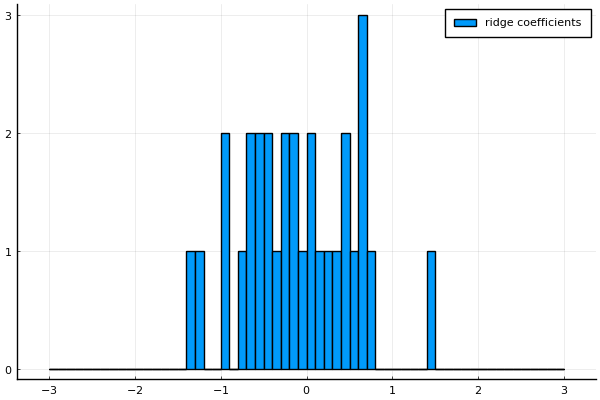

In [31]:
histogram(w_ridge, label="ridge coefficients", bins=-3:.1:3)

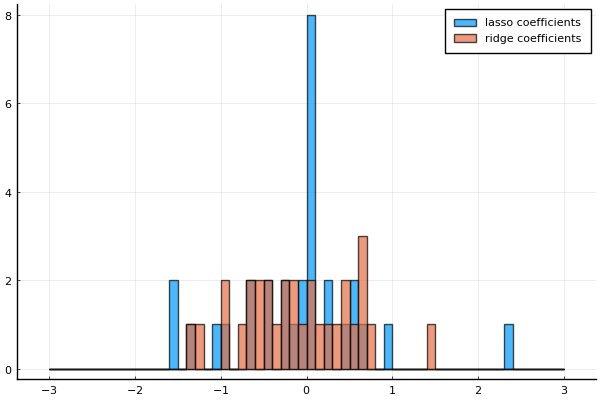

In [32]:
histogram(w_lasso, label="lasso coefficients", bins=-3:.1:3, alpha=.7)
histogram!(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

Which coefficients are more sparse? (More 0 coefficients)
* A) ridge
* B) lasso

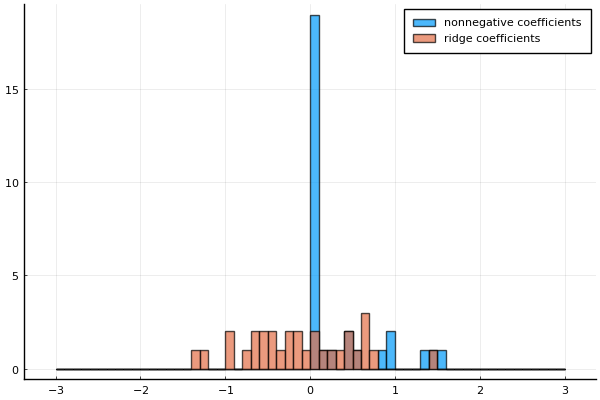

In [33]:
histogram(w_nonneg, label="nonnegative coefficients", bins=-3:.1:3, alpha=.7)
histogram!(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

Which coefficients are more sparse? (More 0 coefficients)
* A) ridge
* B) nonnegative least squares

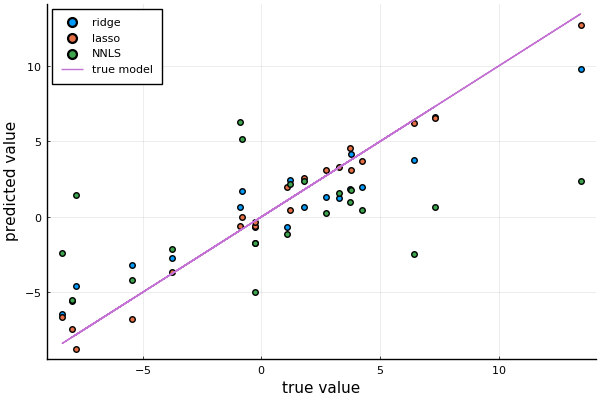

In [17]:
# which fits data best?
Xtest,ytest = generate_data(20,w)

scatter(ytest,Xtest*w_ridge,label="ridge")
scatter!(ytest,Xtest*w_lasso,label="lasso")
scatter!(ytest,Xtest*w_nonneg,label="NNLS")
plot!(ytest,ytest,label="true model")
xlabel!("true value")
ylabel!("predicted value")

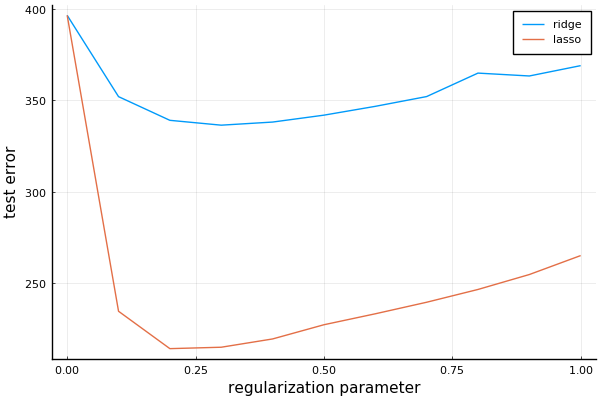

In [18]:
# cross validate over lambda
Random.seed!(1)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

ridge_error = Float64[]
lasso_error = Float64[]
λs = 0:.1:1
for λ in λs
    w = ridge_regression(X,y; λ=λ)
    push!(ridge_error, sum((ytest - Xtest*w).^2))
    w = lasso(X,y; λ=λ)
    push!(lasso_error, sum((ytest - Xtest*w).^2))
end
plot(λs, ridge_error, label="ridge")
plot!(λs, lasso_error, label="lasso")
ylabel!("test error")
xlabel!("regularization parameter")